# Dataset

## Downloading data

In [ ]:
#!g1.1
%pip install --upgrade --no-cache-dir gdown

import requests
# загрузите селебу вашим любимым способом
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py'
open('celeba.py', 'wb').write(requests.get(url).content);
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt'
open('list_attr_celeba.txt', 'wb').write(requests.get(url).content);

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=ceaed608b73c160cc5fadbab8ddd682bcb6fdc81fb77164bc0e8e0cda96c69e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-p8k63jyr/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
#!g1.1
import fileinput

for line in fileinput.input("celeba.py", inplace=True): 
    if fileinput.filelineno() not in [45, 46]: 
        print(line[:-1])
        continue
    if fileinput.filelineno() == 45:
        corrected_line = "                download_url = 'https://drive.google.com/file/d/17NNnHn1RyPPmb4iQqIGJ2XFulfwyW1Sh/view?usp=sharing'"
    else:
        corrected_line = "                gdown.download(download_url, download_path, quiet=False, fuzzy=True)"

    print(corrected_line)

In [ ]:
#!g1.1
from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 
from torch import nn

from torch import Tensor

In [ ]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

In [ ]:
#!g1.1
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image

dataset = CelebaCustomDataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=False
)

img = dataset[0]
img.shape

Downloading...
From: https://drive.google.com/uc?id=17NNnHn1RyPPmb4iQqIGJ2XFulfwyW1Sh
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:07<00:00, 185MB/s]


torch.Size([3, 64, 64])

In [ ]:
#!g1.1
img.max(), img.min()

(tensor(1.), tensor(-1.))

## Visualizing data

In [ ]:
#!g1.1
def plot_img(img, transform=t_invnormalize):
    if transform != None:
        plt.imshow(transform(img).permute(1, 2, 0))
    else:
        plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')

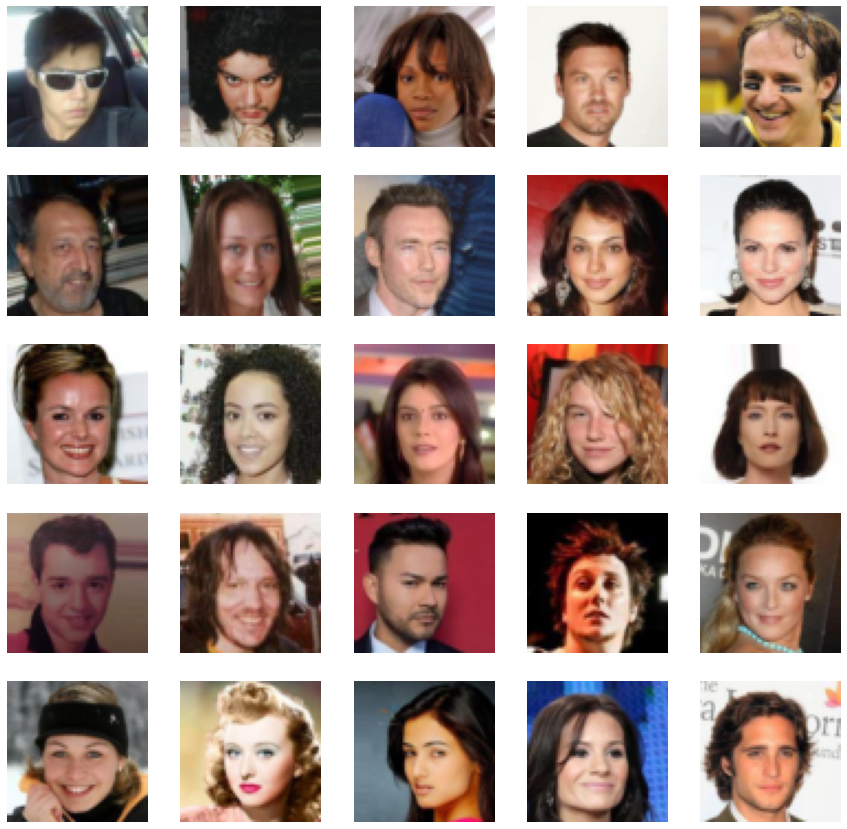

In [ ]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img)
plt.show()

In [ ]:
#!g1.1
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, drop_last=True)
BATCH_PRINT = len(dataloader) // 25

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Normalizing Flow

Architecture from Glow: Generative Flow with Invertible 1x1 Convolutions (Kingma et Dhariwal 2018)


### Imports

In [ ]:
#!g1.1
import itertools
import os
from time import time
from copy import deepcopy

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

In [ ]:
x = torch.tensor([10])
x[None, :, None, None]

### Glow model

#### ActNorm

In [ ]:
#!g1.1
class ActNorm(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        self.register_buffer("init_flag", torch.tensor([0]))

        self.mean = nn.Parameter(torch.zeros(1, in_channel, 1, 1))
        self.var = nn.Parameter(torch.ones(1, in_channel, 1, 1))
        self.EPS = 1e-6
        self.agg_dims = (0, 2, 3)

    def forward(self, x):
        B, C, H, W = x.shape

        #print('fwd', self.init_flag)
        if self.init_flag.item() == 0:
            self.__initialize(x)

        z = (x * self.var) + self.mean
        logdet = torch.log(self.var).sum() * (H * W)

        return z, logdet

    def backward(self, z):
        B, C, H, W = z.shape

        x = (z - self.mean) / self.var
        return x

    def __initialize(self, x):
        ############## Var ##############
        var = torch.std(x, dim=self.agg_dims)
        var = deepcopy(var.detach()).to(device)
        self.var.data = (1 / (self.EPS + var))[None, :, None, None]

        ############## Mean #############
        unsqueezed_var = (self.EPS + var)[None, :, None, None]
        mean = torch.mean(x / unsqueezed_var, dim=self.agg_dims)
        mean = deepcopy(mean.detach()).to(device)
        self.mean.data = (-mean)[None, :, None, None]

        self.init_flag[:] = torch.tensor([1])
        #print(self.init_flag)

#### 1x1 Convolution

In [ ]:
#!g1.1
class Invertible1x1Conv(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        self.C = in_channel
        weight = torch.randn(self.C, self.C)

        Q = torch.nn.init.orthogonal_(weight)

        ############ P & L ############
        P, L, U = torch.lu_unpack(*Q.lu())
        self.register_buffer("P", P)
        self.L = nn.Parameter(L)

        ############## U ##############
        udiag = U.diag()
        ulogdiag = torch.log(torch.abs(udiag))
        self.register_buffer("S_sign", torch.sign(udiag))
        self.S = nn.Parameter(ulogdiag)

        self.U = nn.Parameter(torch.triu(U, diagonal=1))

    def _assemble_weights(self):
        L = torch.tril(self.L, diagonal=-1) + torch.diag(self.L.data.new_ones(self.C))
        U = torch.triu(self.U, diagonal=1)
        S = torch.diag(torch.exp(self.S) * self.S_sign)
        weights = self.P @ L @ (U + S)
        return weights[:, :, None, None]

    def forward(self, x):
        B, C, H, W = x.shape

        weights = self._assemble_weights()
        z = F.conv2d(x, weights)

        logdet = H * W * torch.sum(self.S)
        return z, logdet

    def backward(self, z):
        B, C, H, W = z.shape

        weights = self._assemble_weights()
        weights = torch.inverse(weights.squeeze())[:, :, None, None]
        x = F.conv2d(z, weights)

        return x

#### Affine Coupling

In [ ]:
#!g1.1
class AffineCoupling(nn.Module):
    def __init__(self, in_channel, hidden_dim=512):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channel // 2, hidden_dim, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, in_channel, kernel_size=3, padding=1),
        )
        self.scale = nn.Parameter(torch.zeros((1, in_channel // 2, 1, 1)))
        self.sigmoid = nn.Sigmoid()

        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        B, C, H, W = x.shape

        x1, x2 = torch.chunk(x, 2, dim=1)
        res = self.net(x1)
        res1, res2 = torch.chunk(res, 2, dim=1)
        res1 = res1 * torch.exp(self.scale)

        factor = self.sigmoid(res1 + 2)
        x2 = (x2 + res2) * factor 

        logdet = torch.flatten(torch.log(factor), 1)
        logdet = logdet.sum(1)
        z = torch.cat([x1, x2], 1)

        return z, logdet

    def backward(self, z):
        B, C, H, W = z.shape

        x1, x2 = torch.chunk(z, 2, dim=1)

        res = self.net(x1)
        res1, res2 = torch.chunk(res, 2, dim=1)
        res1 = res1 * torch.exp(self.scale)

        factor = self.sigmoid(res1 + 2)
        x2 = (x2 / factor) - res2

        x = torch.cat([x1, x2], 1)
        return x

#### Squeeze + Flow block

In [ ]:
#!g1.1
class BlockNet(nn.Module):
    def __init__(self, in_channel, block_sz):
        super().__init__()
        mid_channel = in_channel * 4
        norms = [ActNorm(mid_channel) for i in range(block_sz)]
        flows = [Invertible1x1Conv(mid_channel) for i in range(block_sz)]
        coups = [AffineCoupling(mid_channel) for i in range(block_sz)]
        flows = list(itertools.chain(*zip(norms, flows, coups)))
        self.net = NormalizingFlow(flows)

    def forward(self, x):
        return self.net.forward(x)

    def backward(self, z):
        return self.net.backward(z)

class Block(nn.Module):
    def __init__(self, in_channel, block_sz, ways=2):
        super().__init__()
        self.ways = ways

        self.model = BlockNet(in_channel, block_sz)

    def forward(self, x):
        B, C, H, W = x.shape

        weight = x.new_zeros(C * 4, C, 2, 2)

        for i in range(C):
            weight[4 * i + 0, i, 0, 0] = 1
            weight[4 * i + 1, i, 0, 1] = 1
            weight[4 * i + 2, i, 1, 0] = 1
            weight[4 * i + 3, i, 1, 1] = 1
        x2 = F.conv2d(x, weight, stride=2)

        z_left, logdet = self.model.forward(x2)
        z_fwd, log_p = None, 0

        if self.ways == 2:
            z_left, z_fwd = torch.chunk(z_left, self.ways, dim=1)
        
        z_flat = torch.flatten(z_left, 1)
        L = z_flat.shape[1]
        denom = torch.log(z_flat.new_tensor([2 * math.pi]))
        expon = (z_flat ** 2).sum(axis=1) 
        log_p = (-L) * denom / 2 - expon / 2

        return z_fwd, logdet, log_p, z_left


    def backward(self, z):
        x = self.model.backward(z)

        B, C, H, W = x.shape
        C //= 4

        weight = x.new_zeros(C * 4, C, 2, 2)

        for i in range(C):
            weight[4 * i + 0, i, 0, 0] = 1
            weight[4 * i + 1, i, 0, 1] = 1
            weight[4 * i + 2, i, 1, 0] = 1
            weight[4 * i + 3, i, 1, 1] = 1

        x = F.conv_transpose2d(x, weight, stride=2)
        return x

#### Glow pipeline

In [ ]:
class Glow(nn.Module):
    def __init__(
        self, channels, block_sz, block_num, affine=True, conv_lu=True
    ):
        super().__init__()

        self.blocks = nn.ModuleList()
        self.block_num = block_num

        for i in range(self.block_num - 1):
            self.blocks.append(Block(channels, block_sz, ways=2))
            channels *= 2
        self.blocks.append(Block(channels, block_sz, ways=1))

    def forward(self, x):
        log_p = 0
        logdet = 0
        left_zs = []

        for i in range(self.block_num):
            x, curdet, cur_p, left_z = self.blocks[i].forward(x)

            logdet += curdet
            log_p += cur_p

            left_zs.append(left_z)

        return left_zs, log_p, logdet


    def backward(self, z_inputs):
        for i in range(self.block_num):
            if i == 0:
                x = self.blocks[-i - 1].backward(z_inputs[-i - 1])
            else:
                x = torch.cat((z_inputs[-i - 1], x), dim=1)
                x = self.blocks[-i - 1].backward(x)
        return x

#### Normalizing flow wrapper

In [ ]:
class NormalizingFlow(nn.Module):
    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        #print(x.shape)
        m = len(x)
        log_det = x.new_zeros(m)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        return x, log_det

    def backward(self, z):
        m = len(z)
        for flow in self.flows[::-1]:
            z = flow.backward(z)
        return z


class NormalizingFlowModel(nn.Module):
    def __init__(self, prior, flow):
        super().__init__()
        self.prior = prior
        self.flow = flow
    
    def forward(self, x):
        left_zs, log_p, log_det = self.flow.forward(x)
        self.shapes = [z.shape for z in left_zs]
        return left_zs, log_p, log_det

    def backward(self, z_inputs):
        x, log_det = self.flow.backward(z_inputs)
        return x, log_det
    
    def sample(self, num_samples, temp=1):
        shapes = [(num_samples, a, b, c) for _, a, b, c in self.shapes]

        z = self.prior.sample((num_samples,)).to(device) * temp
        z_inputs = torch.chunk(z, 4, dim=1)
        z_inputs = [torch.cat((z_inputs[0], z_inputs[1]), dim=1),
                    z_inputs[2], z_inputs[3]]

        z_inputs = [torch.reshape(z_inputs[i], shapes[i]) 
                    for i in range(len(shapes))]

        x = self.flow.backward(z_inputs)
        return x

### Model test

In [ ]:
#!g1.1
for x in dataloader:
    data_sz = x.shape[1] * x.shape[2] * x.shape[3]
    break

prior = MultivariateNormal(torch.zeros(data_sz), torch.eye(data_sz))

### Training cycle

In [ ]:
#!g1.1
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, drop_last=True)
BATCH_PRINT = len(dataloader) // 25

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
#!g1.1
def string_time(elapsed):
    return "%im %is" %(int(elapsed / 60), int(elapsed % 60))

def show_imgs(sz):
    plt.figure(figsize=(18, 3 * sz))

    imgs = model.sample(6 * sz)

    for index in range(imgs.shape[0]):
        image = imgs[index].detach().cpu()
        plt.subplot(sz, 6, index + 1)
        plot_img(torch.clamp(image, -1, 1))
    plt.show()
    print('\n')

def train_nf(model, optimizer, num_epochs=5, name='nf', continuing=False):
    dir = "./models/" + name + "/"
    if not os.path.exists("./models/"):
        os.mkdir("./models/")
    if not os.path.exists(dir):
        os.mkdir(dir)

    global loss_history, log_p_history, logdet_history
    if not continuing:
        loss_history, log_p_history, logdet_history = [], [], []
    model.train()

    start = time()
    
    for epoch in range(num_epochs):
        print('\n======= Epoch %i / %i =======' %(epoch + 1, num_epochs))
        # ======== training ========
        print('Training...\n')

        for step, x in enumerate(dataloader):
            x = (x + torch.rand_like(x) / 255).to(device)

            _, log_p, logdet = model.forward(x)
            logprob = (log_p + logdet)
            loss = -torch.sum(logprob)

            model.zero_grad()
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            log_p_history.append(log_p.mean().item())
            logdet_history.append(logdet.mean().item())

            if step % BATCH_PRINT == 0 and not step == 0:
                print("Batch %i  of  %i! \n"\
                      "  Mean loss: %.4f \n"\
                      "  Mean prior LL: %.4f \n"\
                      "  Mean logdet: %.4f \n"\
                      "  Elapsed time:"\
                        %(step + 1, len(dataloader),
                        np.array(loss_history[-BATCH_PRINT:]).mean(),
                        np.array(log_p_history[-BATCH_PRINT:]).mean(),
                        np.array(logdet_history[-BATCH_PRINT:]).mean())
                        + string_time(time() - start) + '\n')
                
                show_imgs(2)
                
        scheduler.step()
        if epoch % 2 == 1:
            torch.save(model, dir + name + '_' + str(epoch + 1))

#### Experiment 1

flow = Glow(3, 10, 3), lr=1e-5, noise randn / 255

In [ ]:
#!g1.1
flow = Glow(3, 10, 3)
model = NormalizingFlowModel(prior, flow)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

train_nf(model, optimizer, 2)

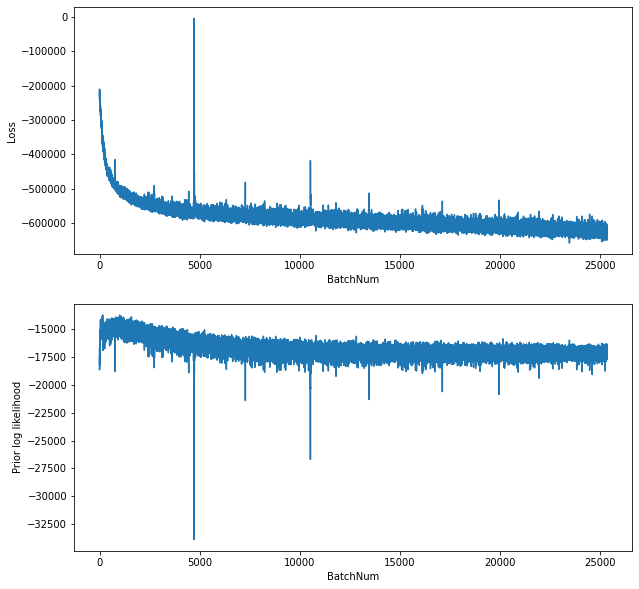

In [ ]:
#!g1.1
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(loss_history)
axs[0].set_xlabel("BatchNum")
axs[0].set_ylabel("Loss")

axs[1].plot(log_p_history)
axs[1].set_xlabel("BatchNum")
axs[1].set_ylabel("Prior log likelihood")

plt.show()

#### Expriment 2

In [ ]:
#!g1.1
flow = Glow(3, 12, 3)
model = NormalizingFlowModel(prior, flow)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_nf(model, optimizer, 3)

<Figure size 432x288 with 0 Axes>

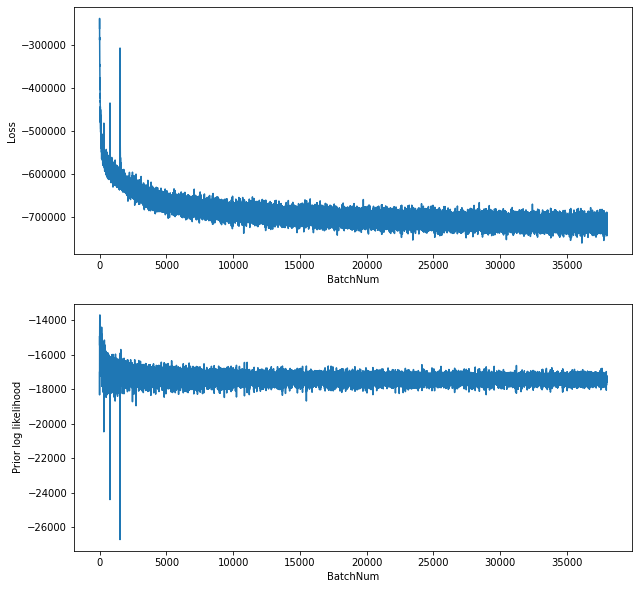

In [ ]:
#!g1.1
plt.figure()

fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(loss_history)
axs[0].set_xlabel("BatchNum")
axs[0].set_ylabel("Loss")

axs[1].plot(log_p_history)
axs[1].set_xlabel("BatchNum")
axs[1].set_ylabel("Prior log likelihood")

plt.show()

#### Experiment 3

In [ ]:
#!g1.1
flow = Glow(3, 12, 3)
model = NormalizingFlowModel(prior, flow)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_nf(model, optimizer, 2)

<Figure size 432x288 with 0 Axes>

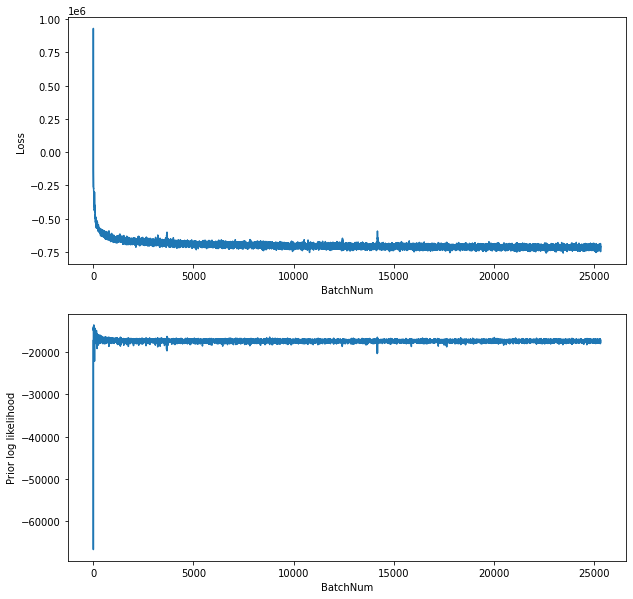

In [ ]:
#!g1.1
plt.figure()

fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(loss_history)
axs[0].set_xlabel("BatchNum")
axs[0].set_ylabel("Loss")

axs[1].plot(log_p_history)
axs[1].set_xlabel("BatchNum")
axs[1].set_ylabel("Prior log likelihood")

plt.show()

#### Experiment 4

In [ ]:
#!g1.1
flow = Glow(3, 15, 3)
model = NormalizingFlowModel(prior, flow)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_nf(model, optimizer, 4)

In [ ]:
#!g1.1
shapes = [(1, 6, 32, 32), (1, 12, 16, 16), (1, 48, 8, 8)]
shapes = [(12, a, b, c) for _, a, b, c in shapes]

z = prior.sample((12,)).to(device) * 0.5
z_inputs = torch.chunk(z, 4, dim=1)
z_inputs = [torch.cat((z_inputs[0], z_inputs[1]), dim=1),
            z_inputs[2], z_inputs[3]]

z_inputs = [torch.reshape(z_inputs[i], shapes[i]) 
            for i in range(len(shapes))]

x = model.flow.backward(z_inputs)

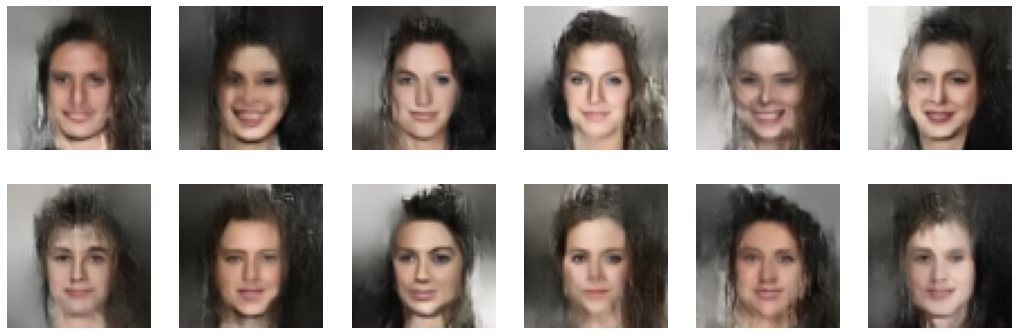

In [ ]:
#!g1.1
plt.figure(figsize=(18, 3 * 2))

imgs = model.sample(temp=0.5)

for index in range(imgs.shape[0]):
    image = imgs[index].detach().cpu()
    plt.subplot(2, 6, index + 1)
    plot_img(torch.clamp(image, 0, 1), None)
plt.show()

<Figure size 432x288 with 0 Axes>

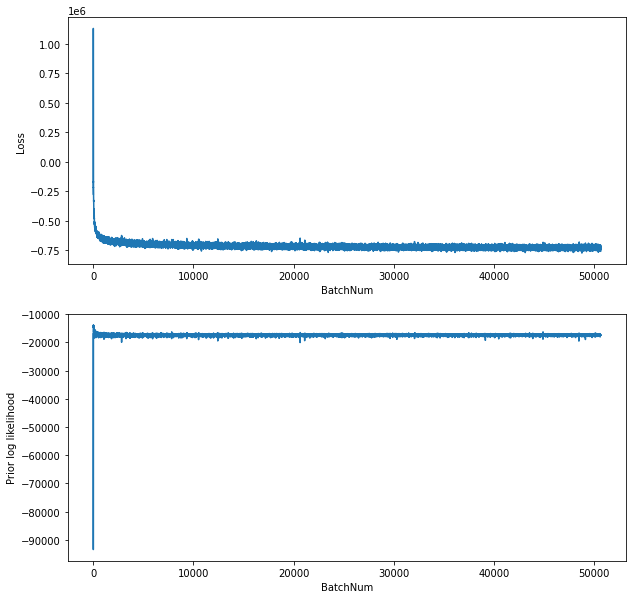

In [ ]:
#!g1.1
plt.figure()

fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(loss_history)
axs[0].set_xlabel("BatchNum")
axs[0].set_ylabel("Loss")

axs[1].plot(log_p_history)
axs[1].set_xlabel("BatchNum")
axs[1].set_ylabel("Prior log likelihood")

plt.show()

In [ ]:
! gdown https://drive.google.com/uc?id=1KCsBgNj9YVQth6uBZPFHACllirRsQK-E

Downloading...
From: https://drive.google.com/uc?id=1KCsBgNj9YVQth6uBZPFHACllirRsQK-E
To: /content/nf_4
100% 1.29G/1.29G [00:06<00:00, 188MB/s]


In [ ]:
#!g1.1
model = torch.load("./nf_4")
calculate_fid()

100% 120/120 [00:13<00:00,  8.99it/s]
100% 120/120 [00:13<00:00,  8.98it/s]


89.33514458641628

#### Experiment 5

In [ ]:
#!g1.1
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, drop_last=True)
BATCH_PRINT = len(dataloader) // 30

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
#!g1.1
flow = Glow(3, 15, 3)
model = NormalizingFlowModel(prior, flow)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)

train_nf(model, optimizer, 5, name='nf')

In [ ]:
#!g1.1
plt.figure()

fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(loss_history)
axs[0].set_xlabel("BatchNum")
axs[0].set_ylabel("Loss")

axs[1].plot(log_p_history)
axs[1].set_xlabel("BatchNum")
axs[1].set_ylabel("Prior log likelihood")

plt.show()

In [ ]:
#!g1.1
shapes = [(1, 6, 32, 32), (1, 12, 16, 16), (1, 48, 8, 8)]
shapes = [(12, a, b, c) for _, a, b, c in shapes]

z = prior.sample((12,)).to(device) * 0.6
z_inputs = torch.chunk(z, 4, dim=1)
z_inputs = [torch.cat((z_inputs[0], z_inputs[1]), dim=1),
            z_inputs[2], z_inputs[3]]

z_inputs = [torch.reshape(z_inputs[i], shapes[i]) 
            for i in range(len(shapes))]

x = model.flow.backward(z_inputs)

In [ ]:
#!g1.1
plt.figure(figsize=(18, 3 * 2))

imgs = model.sample(temp=0.5)

for index in range(imgs.shape[0]):
    image = imgs[index].detach().cpu()
    plt.subplot(2, 6, index + 1)
    plot_img(torch.clamp(image, -1, 1))
plt.show()

#### Experiment 6

In [ ]:
#!g1.1
flow = Glow(3, 25, 3)
model = NormalizingFlowModel(prior, flow)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)

train_nf(model, optimizer, 6, name='large_nf')

In [ ]:
#!g1.1
plt.figure()

fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(loss_history)
axs[0].set_xlabel("BatchNum")
axs[0].set_ylabel("Loss")

axs[1].plot(log_p_history)
axs[1].set_xlabel("BatchNum")
axs[1].set_ylabel("Prior log likelihood")

plt.show()

In [ ]:
#!g1.1
shapes = [(1, 6, 32, 32), (1, 12, 16, 16), (1, 48, 8, 8)]
shapes = [(12, a, b, c) for _, a, b, c in shapes]

z = prior.sample((12,)).to(device) * 0.6
z_inputs = torch.chunk(z, 4, dim=1)
z_inputs = [torch.cat((z_inputs[0], z_inputs[1]), dim=1),
            z_inputs[2], z_inputs[3]]

z_inputs = [torch.reshape(z_inputs[i], shapes[i]) 
            for i in range(len(shapes))]

x = model.flow.backward(z_inputs)

In [ ]:
#!g1.1
plt.figure(figsize=(18, 3 * 2))

imgs = model.sample(temp=0.5)

for index in range(imgs.shape[0]):
    image = imgs[index].detach().cpu()
    plt.subplot(2, 6, index + 1)
    plot_img(torch.clamp(image, -1, 1))
plt.show()

FID after the 2d training epoch:

In [ ]:
#!g1.1
! gdown https://drive.google.com/uc?id=1AiptlaUb6I4wh9GYUbdtKjQ-A-mvoEfE
model = torch.load("./large_nf_2")
calculate_fid()

Downloading...
From: https://drive.google.com/uc?id=1AiptlaUb6I4wh9GYUbdtKjQ-A-mvoEfE
To: /content/large_nf_2
100% 1.35G/1.35G [00:18<00:00, 73.2MB/s]
100% 120/120 [00:13<00:00,  9.01it/s]
100% 120/120 [00:13<00:00,  9.07it/s]


93.40672107624437